In [1]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy import signal
from scipy.stats import norm, pearsonr
from itertools import combinations
%matplotlib inline

In [2]:
# database full path
database_name = 'whistlers.h5'
database_location = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'Data')
database_path = os.path.join(database_location,database_name)

# data variables
awd_events = 2
sites = ['marion', 'sanae']

In [3]:
def scale_to_extreme(arr, thr):
    arr = np.asarray(arr)
    arr_min = arr.min()
    arr_max = arr.max()
    _arr = [arr_min if a < thr else arr_max for a in arr]
    return _arr

In [4]:
def extract_spectrogram_info(spectrogram_data):
    '''Extract the time, frequency axis values as well as the 
            spectrogram data.
    inputs:
        spectrogram_data: the spectrogram data including the 
        time and frequency information.
    outputs: 
        time: time values
        frequency: frequency values
        spectrogram: spectrogram
    '''
    time = spectrogram_data[0,1:]
    frequency = spectrogram_data[1:,0]
    spectrogram = spectrogram_data[1:,1:]
    return time, frequency, spectrogram

Number of files:  2196
2013-10-20UT22:43:27.62419422.marion.vr2
Spectrogram size:  (257, 959)
Time samples:  [0.0032 0.008  0.0128 0.0176 0.0224]
Frequency samples: [  0.     78.125 156.25  234.375 312.5  ]
624 [416, 624, 959] [(416, 624), (416, 959), (624, 959)]
[[2000.33981    9.     ]
 [2000.35681   11.     ]
 [2999.43781   58.     ]
 [2999.45381    7.     ]
 [2999.49581    7.     ]
 [2999.50881   43.     ]
 [2999.99281   23.     ]
 [3000.03481   34.     ]
 [3000.08581   10.     ]
 [3000.10881   55.     ]
 [3000.13581   22.     ]
 [3000.16281   66.     ]]
Spectrogram size:  (257, 416)
416 624 (959,)
624 959 (959,)
Spectrogram size:  (257, 335)


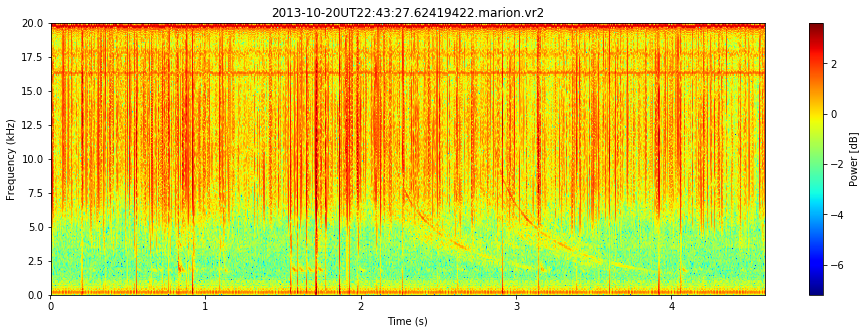

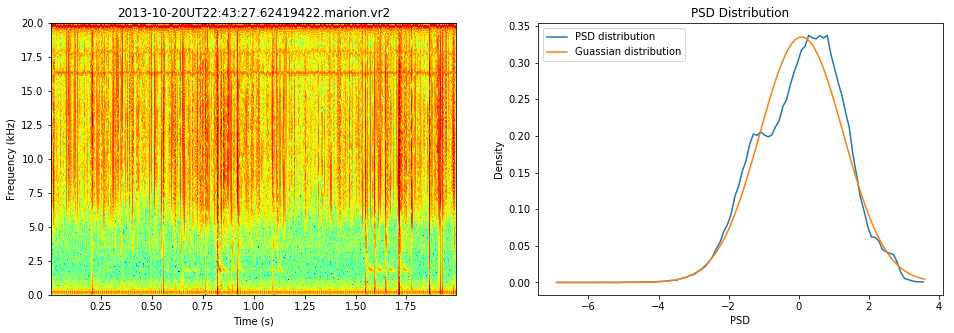

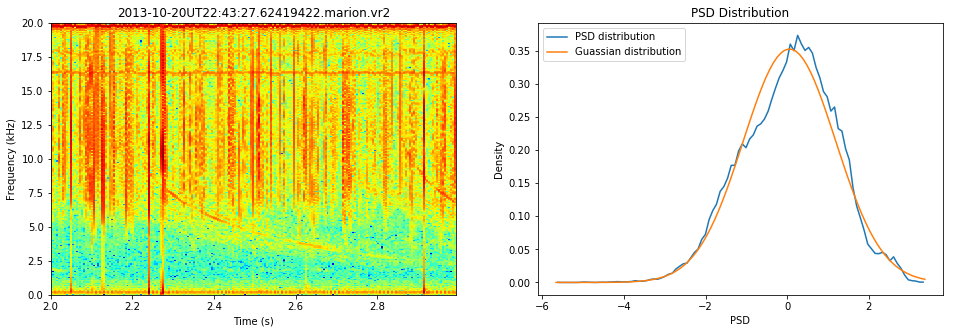

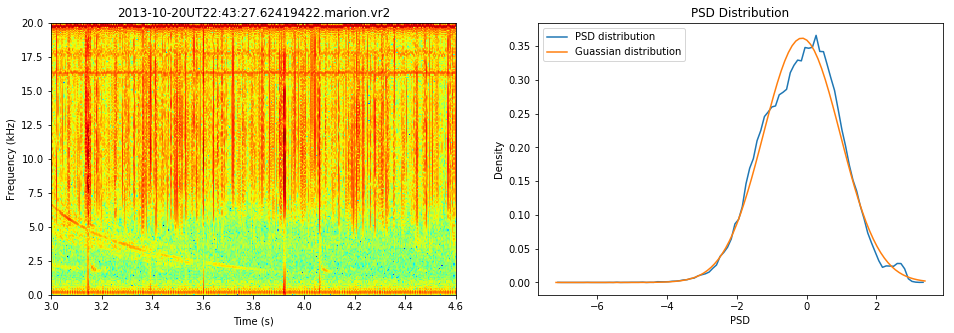

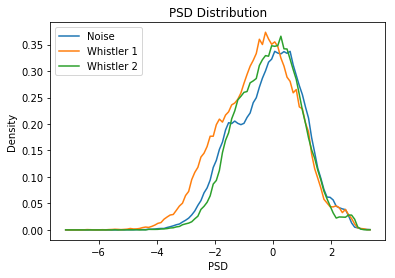

In [47]:
f  = h5py.File(database_path, 'r')
grp_wh = f[os.path.join('awdEvents'+str(1), sites[0],'spectrograms')]
files = list(grp_wh.keys())
print('Number of files: ', len(files))
file = files[np.random.randint(len(files))] # select a random sample
# file = '2013-07-29UT14:22:21.36931914.marion.vr2'
# file = '2013-07-05UT19:02:08.10851914.marion.vr2'
for k in range(1):
    print(file)
    # create np array to store sample information
    data = np.empty(grp_wh[file].shape)
    grp_wh[file].read_direct(data)
    outputs = grp_wh[file].attrs['output']
    # extract data info
    time, freq, Sxx = extract_spectrogram_info(data)

    # center data
    Sxx -= np.mean(Sxx)
    
    fig = plt.figure(figsize=(16,5))
    img = plt.pcolormesh(time,freq/1000,Sxx, cmap='jet')
    fig.colorbar(mappable=img, label='Power [dB]')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (kHz)')
    plt.title(file)
    print('Spectrogram size: ', Sxx.shape)
    print('Time samples: ', time[:5])
    print('Frequency samples:', freq[:5])
    _t = np.round_(time,decimals=3)
    index = 0
    indices = []
    for output in outputs:
        event_time = np.round(output[0]/1000,3)
        # find index of that event in the spectrogram
        index = min(range(len(_t)), key=lambda i: abs(_t[i]-event_time))
        # only process if the index found is new
        if index!=0 and index not in indices:
            indices.append(index)
    events = sorted(outputs[:,1], reverse=True)[:len(indices)] # map prob to to event correctly
    indices.append(time.shape[0])
    event_indices = list(combinations(indices,2))
    
    print(index,indices, list(event_indices))
    print(outputs)
    # get eventless section of spectrogram
    Sxx_no_event, dump = np.hsplit(Sxx, [indices[0]])
    t_no_event, dump = np.hsplit(time, [indices[0]])
    
    # compute histogram
    # get mean
    mean = np.mean(Sxx_no_event)
    std = np.std(Sxx_no_event)
    # Compute histogram
    (n, bins) = np.histogram(Sxx_no_event.flatten(), bins=100, density=True)  # NumPy version (no plot)
    # Compute pdf
    pdf = norm.pdf(bins, mean, std)
    
    fig = plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.pcolormesh(t_no_event,freq/1000,Sxx_no_event, cmap='jet')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (kHz)')
    plt.title(file)
    plt.subplot(1,2,2)
    plt.plot(.5*(bins[1:]+bins[:-1]), n)
    plt.plot(bins, pdf)
    plt.title('PSD Distribution')
    plt.xlabel('PSD')
    plt.ylabel('Density')
    plt.legend(['PSD distribution', 'Guassian distribution'])
    print('Spectrogram size: ', Sxx_no_event.shape)
    # get event sections of spectrogram
    _n = []
    _n.append(n)
    for i in range(len(indices)-1):
        print(indices[i], indices[i+1], time.shape)
        Sxx_event = Sxx[:,indices[i]:indices[i+1]]
        t_event = time[indices[i]:indices[i+1]]
        # compute histogram
        # get mean
        mean = np.mean(Sxx_event)
        std = np.std(Sxx_event)
        # Compute histogram
        (n, bins) = np.histogram(Sxx_event.flatten(), bins=100, density=True)  # NumPy version (no plot)
        _n.append(n)
        # Compute pdf
        pdf = norm.pdf(bins, mean, std)
        plt.figure(figsize=(16,5))
        plt.subplot(1,2,1)
        plt.pcolormesh(t_event,freq/1000,Sxx_event, cmap='jet')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (kHz)')
        plt.title(file)
        plt.subplot(1,2,2)
        plt.plot(.5*(bins[1:]+bins[:-1]), n)
        plt.plot(bins, pdf)
        plt.title('PSD Distribution')
        plt.xlabel('PSD')
        plt.ylabel('Density')
        plt.legend(['PSD distribution', 'Guassian distribution'])
    print('Spectrogram size: ', Sxx_event.shape)
    break
f.close()
plt.figure()
for n in _n:
    plt.plot(.5*(bins[1:]+bins[:-1]), n)
plt.title('PSD Distribution')
plt.xlabel('PSD')
plt.ylabel('Density')
plt.legend(['Noise', 'Whistler 1', 'Whistler 2', 'Whistler 3'])

perfect distribution

2013-07-10UT19:19:44.00611938.marion.vr2

off

2013-07-26UT03:38:16.07011914.marion.vr2
2013-07-02UT16:04:12.19171914.marion.vr2
2013-07-04UT18:43:52.37731922.marion.vr2

strange distribution

2013-10-20UT22:36:37.25619422.marion.vr2

long

2013-07-26UT03:47:01.17731914.marion.vr2  # one event is blank
2013-05-18UT13:43:46.27112156.marion.vr2

wrong label
2013-07-02UT16:14:20.65251914.marion.vr2

